In [1]:
import torch
import torch.nn.functional as F

dim = 1024
datatype = 'bipolar'
operation = 'MAP'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 随机向量产生
## 1. 任意的 HV

In [2]:
# TODO

def CA90(vec):
    """
    Function
    ===
    CA90 rule. Next = (vec << 1) ^ (vec >> 1) where input vectors are cylic shift.
    """
    vec_left = torch.roll(vec, shifts=-1, dims=0)
    vec_right = torch.roll(vec, shifts=1, dims=0)   

    return vec_left ^ vec_right

In [3]:
def item_memory(dim, number, datatype='bipolar'):
    """
    Function
    ===
    Generate random vectors

    Parameter
    ---
    Data type must be 'bipolar' by now so that the element is within {-1, 1}

    Return
    ---
    A tensor with a size of (number, dim)
    """
    # Function `randint` ranges from 0 to 2 (0 included, 2 not included). 
    table = torch.randint(low=0, high=2, size=(number, dim), dtype=torch.int8)

    if datatype == 'bipolar':
        table[table == 0] = -1
    elif datatype == 'polar':
        pass
    else:
        raise ValueError('Sorry, currently only supporting bipolar datatype.')
    
    return table

IM_3 = item_memory(dim=dim, number=3, datatype=datatype)
IM_3, CA90(IM_3)

(tensor([[-1, -1,  1,  ..., -1, -1, -1],
         [-1, -1,  1,  ..., -1, -1, -1],
         [-1,  1,  1,  ..., -1,  1, -1]], dtype=torch.int8),
 tensor([[ 0, -2,  0,  ...,  0, -2,  0],
         [ 0, -2,  0,  ...,  0, -2,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]], dtype=torch.int8))

## 2. 连续级别的 HV CiM

## 3. 循环的 circlar


# MAP 操作
对于 {-1, 1}，硬件二值逻辑表示为 {0 -> -1, 1 -> 1}

- bind

- bundle

- permutation




In [4]:
# TODO
def bind(hv1, hv2):
    """
    Function
    ===
    Element-wise operation.
    For {-1, 1}, bind is *.
    For {0, 1}, bind is XOR.

    """    
    return hv1 * hv2

def bundle(hv1, hv2):
    """
    Function
    ===
    Bundle the HDvectors together using element-wise addition.
    if the sum >= 1, set to 1; else set to 0

    """
    #return hv1 + hv2
    return ((hv1 + hv2) > 0).int() * 2 - 1

def permutation(hv):
    """
    Function
    ===
    Permutation the input vec.
    Right shift by 1 element.
    """
    return hv.roll(hv, shifts=1, dims=0)

# 相似性度量

Hamming & cosine

In [5]:
def similarity(hv1, hv2, stype='cos'):
    if stype == 'cos':
        return F.cosine_similarity(hv1.float(), hv2.float(), dim=0)
    elif stype == 'ham':
        ham = hv1 ^ hv2
        return torch.sum(ham != 0)

In [6]:
def inter_cos_simi(hvs1, hvs2, stype='cos'):
    """
    Function
    ===
    First expand the shape (n, dim) to (n, 1, dim) and (m, dim) to (1, m, dim) so that they can broadcast to compare.
    Then calculate the similarity in the last dimension(dim=2)
    
    Parameter
    ---
    (n, dim) & (m, dim) vector

    Return
    ---
    matrix (n, m) representing the similarity between the n and m HVs.
    """
    similarity_matrix = F.cosine_similarity(hvs1.float().unsqueeze(dim=1),
                                            hvs2.float().unsqueeze(dim=0), dim=2)

    return similarity_matrix

simi = inter_cos_simi(hvs1=IM_3, hvs2=IM_3)

热力图表示相似度

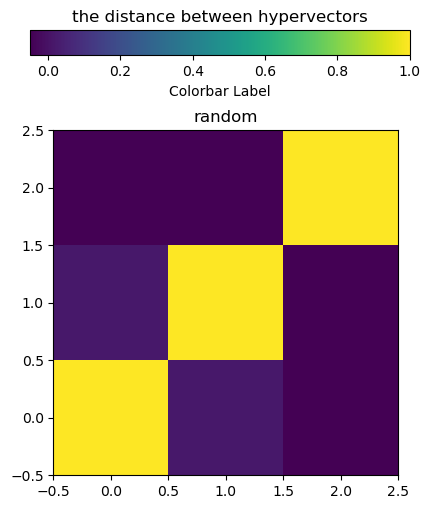

In [7]:
import matplotlib.pyplot as plt

def plt_simi(simi_mat, size=(5, 5)):
    """
    Function
    ===
    Plot the heatmap of the input matrix
    
    Paramter
    ---
    simi_mat: a (n, m) matrix
    """
    # 创建一个图形窗口
    fig, axs = plt.subplots(1, 1, figsize=size)

    # 绘制第一个热力图
    cax1 = axs.imshow(simi_mat, origin = 'lower', cmap = 'viridis')  # 'hot'是颜色映射，可以根据需要选择其他颜色映射
    axs.set_title('random')


    # 创建一个空的子图用于颜色条
    cax = fig.add_axes([0.12, 0.95, 0.76, 0.05])  # [left, bottom, width, height]
    # 添加颜色条
    cbar = fig.colorbar(cax1, cax = cax, orientation='horizontal')

    # 设置颜色条的位置
    cbar.set_label('Colorbar Label')

    # 调整子图之间的间距，为颜色条腾出空间
    plt.subplots_adjust(top = 0.8)
    plt.title("the distance between hypervectors")
    plt.show()

plt_simi(simi_mat=simi)

## 两种相似度量的关系

证明对于 bipolar {-1, 1} 来说，Hamming 和 cos 有线性关系
$$
cos(H_1, H_2) = 1 - 2/D_{hv} Hamming(H_1, H_2)
$$

In [8]:
vech1 = torch.randint(low=0, high=2, size=(dim, )) * 2 - 1
vech2 = torch.randint(low=0, high=2, size=(dim, )) * 2 - 1

cos_simi = similarity(vech1, vech2, stype='cos')
ham_simi = similarity(vech1, vech2, stype='ham')

cos_simi.item(), 1 - 2/dim * ham_simi.item(), ham_simi.item()

(-0.015625, -0.015625, 520)

# 字母表的例子


In [9]:
import string

# create a list of the alphabet of lowercase letters
lower_alpha_concepts = list(string.ascii_lowercase)
lower_alpha_IM = item_memory(dim=dim, number=len(lower_alpha_concepts))

In [10]:
apple = "apple"
set_apple = list(apple)
set_apple, len(set_apple)

(['a', 'p', 'p', 'l', 'e'], 5)

In [11]:
def fetch_word(word, IM, concepts):
    """
    Function
    ===
    Get the correspnding HVs of the letters within the word in given item memory.

    Parameter
    ---
    alphabet_IM: the IM for alphbet(lower or upper case)
    word: the word needed to be projected to the IM

    Return
    ---
    A list of HVs representing the word.
    """
    # make sure all the letter in the word is in the alphabet
    if all(letter in concepts for letter in word):
        indices = [concepts.index(letter) for letter in word]
        return IM[indices]
    else:
        raise ValueError("Input word contains invalid characters")

hv_letters_apple = fetch_word(word=set_apple, IM=lower_alpha_IM, concepts=lower_alpha_concepts)

## 单词的相似度
首先展示内部各个字母相对于整个字母表，明显不同字母是正交的。
然后将整个单词的 HV 相加，只有对应字母的相似度偏高。

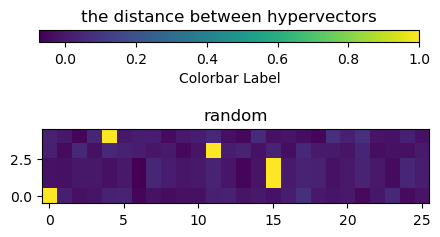

y axis: 0-25 a-z
x axis: the seperative letters from bottom to top


In [37]:
letters_simi = inter_cos_simi(hvs1=hv_letters_apple, hvs2=lower_alpha_IM)
plt_simi(simi_mat=letters_simi, size=(5, 2.5))
print("y axis: 0-25 a-z")
print("x axis: the seperative letters from bottom to top")

The above calculation is the seperative similarity of hvs to the IM.
The below adds the letters' hvs together.

## 不同字母相加
这里仅把不同字母 HV 相加，即 bundle 操作。

In [15]:
# repeat(n, m)
# repeat the tensor by n times in dim=0, by m times in dim=1
hv_word_apple = hv_letters_apple.sum(dim=0, keepdim=True)
hv_word_apple.shape, hv_word_apple, hv_word_apple

(torch.Size([1, 1024]),
 tensor([[ 1, -3, -1,  ...,  5, -5, -1]]),
 tensor([[ 1, -3, -1,  ...,  5, -5, -1]]))

In [25]:
def plt_simi_bar(x_labels, y_values, bar_title, bar_size=(6.5, 3), num_thr=0.3):
    """
    Function
    ===
    Plot bar graph.

    Parameter
    ---

    """
    plt.figure(figsize=bar_size)
    plt.bar(x_labels, y_values, color="gold")

    for i, value in enumerate(y_values):
        if value > num_thr:
            plt.text(i, value, f"{value:.2f}", ha='center')

    plt.title(bar_title)
    plt.xlabel('Categories')
    plt.ylabel('Values')
    plt.show()

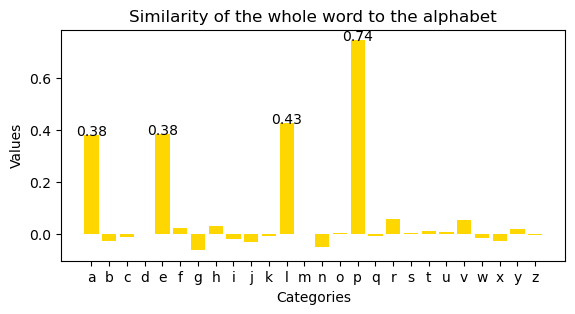

y axis: 0-25 a-z
x axis: the whole word
The distance of the letter within 'apple' is shorter than the other letters in the alphabet.


In [26]:
# squeeze() remove all the dims that equals 1
# squeeze(dim) specifies the dim to be removed
simi_apple = inter_cos_simi(hvs1=hv_word_apple, hvs2=lower_alpha_IM)
plt_simi_bar(x_labels=lower_alpha_concepts, y_values=simi_apple.squeeze(dim=0),
             bar_title="Similarity of the whole word to the alphabet", bar_size=(6.5, 3))
print("y axis: 0-25 a-z")
print("x axis: the whole word")
print("The distance of the letter within 'apple' is shorter than the other letters in the alphabet.")

对上面 bundle 即求和之后的向量进行量化。上面的元素取值是{-1, 1}，计算 5 个和，阈值取 0。

这个例子中，量化后对最出现了 2 次的字母 'p' 影响不大，但是其他字母的相似度下降较多。

In [39]:
def quant(hv, thre):
    return torch.where(hv > thre, torch.ones_like(hv),
                                 torch.full_like(hv, -1))

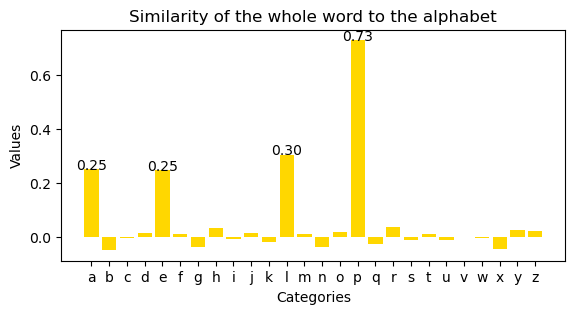

y axis: 0-25 a-z
x axis: the whole word
The distance of the letter within 'apple' is shorter than the other letters in the alphabet.


In [40]:
threshold = 0
hv_word_apple_quat = quant(hv_word_apple, thre=threshold)

simi_quat_apple = inter_cos_simi(hvs1=hv_word_apple_quat, hvs2=lower_alpha_IM)
plt_simi_bar(x_labels=lower_alpha_concepts, y_values=simi_quat_apple.squeeze(dim=0),
             bar_title="Similarity of the whole word to the alphabet", bar_size=(6.5, 3), num_thr=0.2)
print("y axis: 0-25 a-z")
print("x axis: the whole word")
print("The distance of the letter within 'apple' is shorter than the other letters in the alphabet.")

## 基于 sequence
按顺序，每个字母都会依次移位，然后相加(bundle)；相乘(bind)。
只有首字母的相似度被保留。

In [ ]:
def sequence(word, IM, concepts, operation='bind'):
    """
    Function
    ===
    Get the representations of the sequence. 
    Fetch the corresponding vectors of concepts in item memory (num, dim).
    Roatate them by the sequence index.

    Parameter
    ---

    Return
    ---
    """
    letters = fetch_word(word=word, IM=IM, concepts=concepts)
    # for each one-dimension tensor, rotate by index.
    letters = torch.stack([torch.roll(x, shifts=i) for i, x in enumerate(letters)])

    if operation == 'bundle':
        return letters.sum(dim=0, keepdim=True)
    elif operation == 'bind':
        return torch.prod(letters, dim=0, keepdim=True)
    else:
        raise ValueError("not supported operation(bindle, bundle)")


### sequence 区分了顺序
a-b-c 和 a-c-b 是不同的。这里用 bind 操作
$$
\begin{align}
V_1 &= \rho \rho A * \rho B * C \\
V_2 &= \rho \rho A * \rho C * B \\
cos(V_1, V_2) &\approx 0
\end{align}
$$

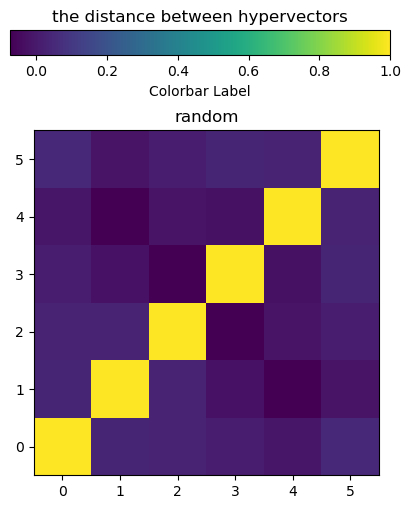

y axis: random sequence of 'abc'
x axis: random sequence of 'abc'


In [ ]:
seq_abc = ["abc", "acb", "bac", "bca", "cab", "cba"]
hv_abc = torch.zeros(size=(len(seq_abc), dim))

for i, seq in enumerate(seq_abc):
    hv_abc[i] = sequence(word=list(seq), IM=lower_alpha_IM, \
                  concepts=lower_alpha_concepts, operation='bind')

abc_simi = inter_cos_simi(hv_abc, hv_abc)
plt_simi(simi_mat=abc_simi, size=(5, 5))
print("y axis: random sequence of 'abc'")
print("x axis: random sequence of 'abc'")

通过 bundle 创建 sequence 即 (a + b' + c'' + ...)，显示其和字母表的相似度。同时可以通过移位，查找单词中不同位置的字母和字母表的相似度。
和上面不同，上面是直接相加(a + b + c + ...)。所以可以看到，不同位置的 'p' 相似度也有不同。

对这个例子量化，相似度有稍微下降，从 0.42 -> 0.38。

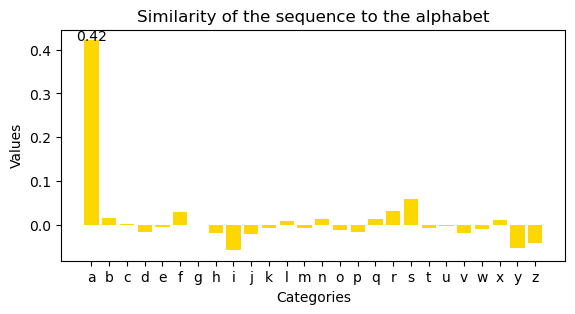

x axis: 0-25 a-z
y axis: the sequence
The sequence is 'a -> p -> p -> l -> e'.
The distance of the letter 'a' is shorter in the alphabet.


In [44]:
hv_seq = sequence(word=set_apple, IM=lower_alpha_IM, \
                  concepts=lower_alpha_concepts, operation='bundle')

threshold = 0
# hv_seq = quant(hv_seq, thre=threshold)

seq_simi_apple = inter_cos_simi(hvs1=hv_seq, hvs2=lower_alpha_IM)
plt_simi_bar(x_labels=lower_alpha_concepts, y_values=seq_simi_apple.squeeze(dim=0),
             bar_title="Similarity of the sequence to the alphabet", bar_size=(6.5, 3))
print("x axis: 0-25 a-z")
print("y axis: the sequence")
print("""The sequence is 'a -> p -> p -> l -> e'.
The distance of the letter 'a' is shorter in the alphabet.""")


### 交互式查看 rotate 的变化

- 定义函数：它接受一个或多个参数，并执行一些操作（比如绘图）。

- 使用interact：指定要交互的参数名称和范围。

- 创建交互式控件：interact会根据你提供的参数范围自动创建一个或多个控件（如滑块、下拉菜单等）。

- 调用函数：当用户与控件交互时，interact会自动调用你的函数，并传递控件的值作为参数。

In [45]:
def interact_plt_seq(rotate):
      seq_simi = inter_cos_simi(hvs1=torch.roll(hv_seq, shifts=-rotate), hvs2=lower_alpha_IM)
      plt_simi_bar(x_labels=lower_alpha_concepts, y_values=seq_simi.squeeze(dim=0),
                  bar_title="Similarity of the sequence to the alphabet", bar_size=(6.5, 3))
      print("x axis: 0-25 a-z")
      print(f"y axis: the sequence rotated by {rotate}")
      print("""The sequence is 'a -> p -> p -> l -> e'.
      The sequence is based on bundling.""")
      print(f"After rotating by {rotate}, the distance of the letter "\
            f"'{set_apple[rotate]}' is shorter in the alphabet.")

In [ ]:
from ipywidgets import interact
import ipywidgets

interact(interact_plt_seq, rotate=ipywidgets.IntSlider(min=0, max=len(set_apple)-1, step=1, value=3));

interactive(children=(IntSlider(value=3, description='rotate', max=4), Output()), _dom_classes=('widget-intera…

# n-gram

## 示例

解释 n-gram 的方法:
一串序列每$n_{gram}$个字母组成一个序列，然后获得$gram_{num} = len - n_{gram}+1$个序列，将所有序列相加。对于 tensor 的操作如下：

$len = 4, n_{gram}=3$

hv1, hv2, hv3, hv4

hv2_r1, hv3_r1, hv4_r1, (hv1_r1)

hv3_r2, hv4_r2, (hv1_r2, hv2_r2)

|前 $gram_{num}$ 组合（以bundle 乘法）

seq1, seq2

In [23]:
import sys
sys.path.insert(0, '/home/maria/py/dl/my_d2l')

from my_package import timer
timer = timer.Timer()
timer.stop()

hvs = torch.arange(1, 13).reshape(4, 3).repeat(3, 1, 1)
hvs

tensor([[[ 1,  2,  3],
         [ 4,  5,  6],
         [ 7,  8,  9],
         [10, 11, 12]],

        [[ 1,  2,  3],
         [ 4,  5,  6],
         [ 7,  8,  9],
         [10, 11, 12]],

        [[ 1,  2,  3],
         [ 4,  5,  6],
         [ 7,  8,  9],
         [10, 11, 12]]])

这两种 tensor 的实现方法效率无法区分，都可以使用

In [24]:
aroll_hvs = torch.zeros_like(hvs)
broll_hvs = torch.zeros_like(hvs)
timer.start()
for i, x in enumerate(hvs):
        aroll_hvs[i] = torch.roll(x, shifts=(-i, i), dims=(0, 1))
print(f'{timer.stop():.5f} sec')
timer.start()
broll_hvs = torch.stack([torch.roll(x, shifts=(-i, i), dims=(0, 1)) for i, x in enumerate(hvs)])
print(f'{timer.stop():.5f} sec')
torch.equal(aroll_hvs, broll_hvs)

0.00025 sec
0.00029 sec


True

In [25]:
one_n_gram = torch.stack([torch.roll(x, shifts=i) for i, x in \
                          enumerate(torch.arange(1, 10).reshape(3, 3))])
print(f"""This is the sequence of the first 3-gram:\
 {torch.prod(one_n_gram, dim=0, keepdim=True)}.
It should equals to part of the next result.""")

This is the sequence of the first 3-gram: tensor([[ 48,  72, 105]]).
It should equals to part of the next result.


In [26]:
print(broll_hvs, broll_hvs.shape)
all_grams = broll_hvs.prod(dim=0)
print(f"all posible n-gram: {all_grams}")
print(f"""only sum up valid n-gram
([0 : 2] contains index-0 not contains index 2):
      {all_grams[0 : 2].sum(dim=0)}""")

tensor([[[ 1,  2,  3],
         [ 4,  5,  6],
         [ 7,  8,  9],
         [10, 11, 12]],

        [[ 6,  4,  5],
         [ 9,  7,  8],
         [12, 10, 11],
         [ 3,  1,  2]],

        [[ 8,  9,  7],
         [11, 12, 10],
         [ 2,  3,  1],
         [ 5,  6,  4]]]) torch.Size([3, 4, 3])
all posible n-gram: tensor([[ 48,  72, 105],
        [396, 420, 480],
        [168, 240,  99],
        [150,  66,  96]])
only sum up valid n-gram
([0 : 2] contains index-0 not contains index 2):
      tensor([444, 492, 585])


n gram 在 NLP 的用法

In [ ]:
def generate_ngrams(text, n):
    """
    生成给定文本的n-grams。
    :param text: 输入的文本字符串
    :param n: n-gram的大小
    :return: 生成的n-grams列表
    """
    tokens = text.lower().split()
    ngrams = []
    max_index = len(tokens) - n + 1
    for i in range(max_index):
        gram = ' '.join(tokens[i:i+n])
        ngrams.append(gram)
    return ngrams

# 示例使用
text = "n grams example e as dfsaf "
n = 3
ngrams = generate_ngrams(text, n)
print(f"生成的{n}-grams如下：")
for ngram in ngrams:
    print(ngram)

生成的3-grams如下：
n grams example
grams example e
example e as
e as dfsaf


## 完整实现

In [114]:
def ngram(text, IM, concepts, n_gram=3):
    """
    Function
    ===
    Representation of n-gram statistics
    Fetch the HVs for the data, a (num, dim) tensor.
    Expand to (n_gram, num, dim), and rotate by sequence. gram = num - n_gram + 1
    Then add all to get all the n-gram HVs

    Parameter
    ---
    item_memory: the item memory contains all the HVs for characters in `data`.
    data: the input sentence
    n_gram: sequence every n consecutive letters

    Return
    ---

    """
    hv_data = fetch_word(word=text, IM=IM, concepts=concepts).repeat(n_gram, 1, 1)
    hv_data = torch.stack([torch.roll(x, shifts=(-i, i), dims=(0, 1)) for i, x in enumerate(hv_data)])

    # Go via all n-grams, bundle(multile consecutive n letters)
    HDgram = hv_data.prod(dim=0)

    # add together only the fisrt `gram_num` hvs
    # 0, 1, ..., len(data) - 1
    # 0 -> n_gram - 1
    gram_num = len(text) - n_gram + 1
    return HDgram[0 : gram_num].sum(dim=0, keepdim=True)

### 功能验证
这里验证，对于长度 n_gram 的序列，就是前面的 sequence 表示。
验证，n-gram 就是子序列的和(bundle)。

In [110]:
ahv_sent = sequence(word=list("abcd"), IM=lower_alpha_IM, \
                    concepts=lower_alpha_concepts, operation='bind')
bhv_sent = ngram(text=list("abcd"), IM=lower_alpha_IM, \
                 concepts=lower_alpha_concepts, n_gram=4)
(ahv_sent == bhv_sent).all()

tensor(True)

In [111]:
hv_sent1 = sequence(word=list("abc"), IM=lower_alpha_IM, \
    concepts=lower_alpha_concepts, operation='bind')
hv_sent2 = sequence(word=list("bcd"), IM=lower_alpha_IM, \
    concepts=lower_alpha_concepts, operation='bind')

print(inter_cos_simi(hvs1=hv_sent1, hvs2=hv_sent2))

tensor([[-0.0039]])


In [115]:
sent1 = list("abcd")
hv_data = fetch_word(word=sent1, IM=lower_alpha_IM, concepts=lower_alpha_concepts).repeat(3, 1, 1)
hv_data = torch.stack([torch.roll(x, shifts=(-i, i), dims=(0, 1)) for i, x in enumerate(hv_data)])
HDgram = hv_data.prod(dim=0)
print(hv_sent1)
print(hv_sent2)
print((HDgram[0] == hv_sent1).all())
print((HDgram[1] == hv_sent2).all())
# the
s = ngram(text=list("abcd"), IM=lower_alpha_IM, \
    concepts=lower_alpha_concepts)
torch.equal(s, hv_sent1 + hv_sent2)


tensor([[ 1, -1, -1,  ...,  1,  1,  1]])
tensor([[-1,  1,  1,  ..., -1,  1, -1]])
tensor(True)
tensor(True)


True

## 字符串对比
实验发现，有相似子字符串时，相似度会比较高；只有字符相同不一定相似；如果没有连续相同字符串时，相似度不高。

In [126]:
# For now, only use lower case letters.
n_gram = 3

def compare_sent(sent1, sent2):
    """
    Function
    ===
    Calculate cosine similarity to two sentences.

    """
    hdg1 = ngram(text=sent1, IM=lower_alpha_IM, \
        concepts=lower_alpha_concepts)

    hdg2 = ngram(text=sent2, IM=lower_alpha_IM, \
        concepts=lower_alpha_concepts)

    print(f"""cos similarity between "{"".join(sent1)}" and "{"".join(sent2)}" is:
        {inter_cos_simi(hdg1, hdg2)[0][0]}
    """)

compare_sent(list("tothemoon"), list("totheloon"))
compare_sent(list("tothemoon"), list("togheloon"))
compare_sent(list("tothemoon"), list("dejavu"))
compare_sent(list("tothemoon"), list("moontothe"))
compare_sent(list("tothemoon"), list("mtotnohoe"))
compare_sent(list("tothemoon"), list("moon"))

cos similarity between "tothemoon" and "totheloon" is:
        0.5636947751045227
    
cos similarity between "tothemoon" and "togheloon" is:
        0.11157125979661942
    
cos similarity between "tothemoon" and "dejavu" is:
        -0.03561421483755112
    
cos similarity between "tothemoon" and "moontothe" is:
        0.7430306673049927
    
cos similarity between "tothemoon" and "mtotnohoe" is:
        0.10683146119117737
    
cos similarity between "tothemoon" and "moon" is:
        0.5390172600746155
    
